## Семинар 8: "Снижение размерности"

ФИО: Александр Лыжов

In [33]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline
from tqdm import tqdm
from sklearn.cluster import KMeans

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

downloading Olivetti faces from http://cs.nyu.edu/~roweis/data/olivettifaces.mat to /home/nikkou/scikit_learn_data


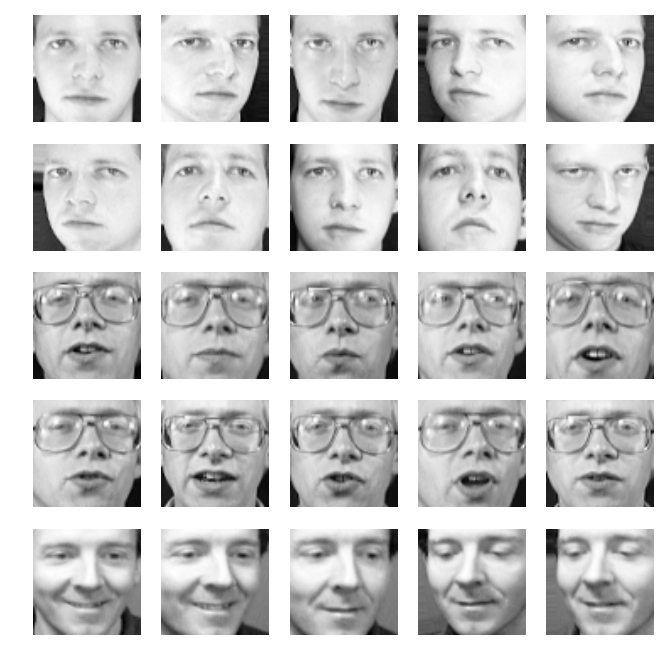

In [3]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

In [12]:
n_comp = 25

In [5]:
pca = PCA(n_comp)

In [8]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

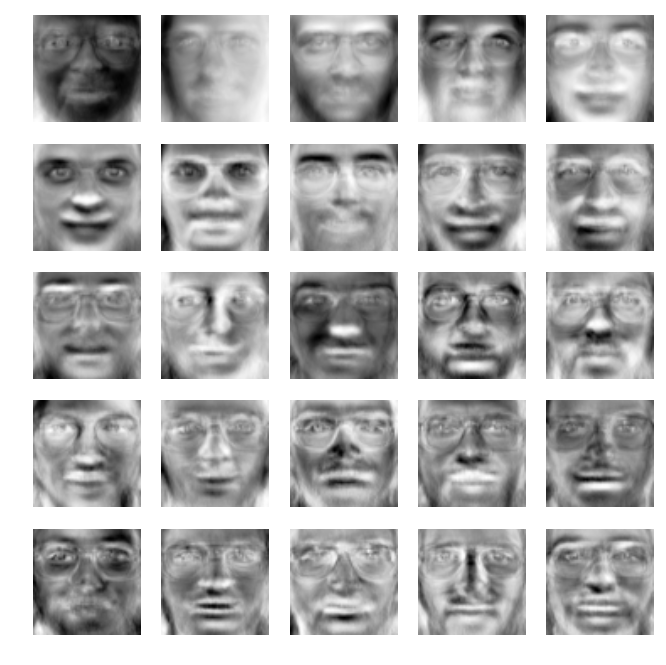

In [13]:
plt.figure(figsize=(8, 8))
for i in xrange(n_comp):
    plt.subplot(5, 5, i+1)
    plt.imshow(pca.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>
Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

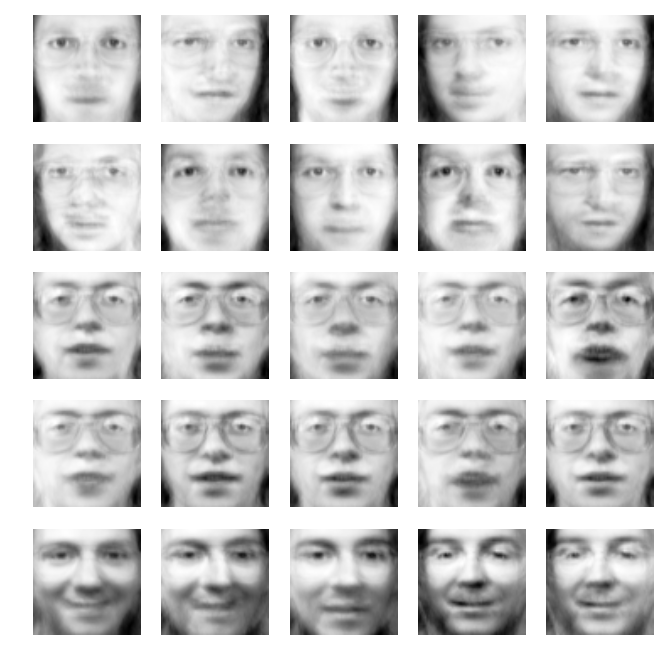

In [47]:
n_comp = 25
pca = PCA(n_comp)
t = pca.fit_transform(X)
invt = pca.inverse_transform(t)
plt.figure(figsize=(8, 8))
for i in xrange(n_comp):
    plt.subplot(5, 5, i+1)
    plt.imshow(invt[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

In [39]:
max_n_comp = 100
errors = np.empty((max_n_comp))
for n_comp in tqdm(xrange(0, max_n_comp)):
    pca = PCA(n_comp)
    t = pca.fit_transform(X)
    invt = pca.inverse_transform(t)
    error = ((X - invt) ** 2).sum(axis = 1).mean(axis = 0)
    errors[n_comp] = error

100%|██████████| 100/100 [00:36<00:00,  1.81it/s]


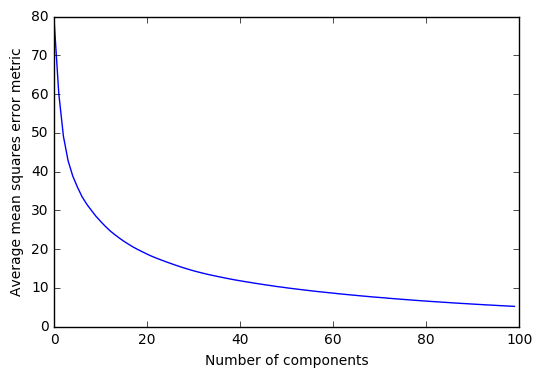

In [45]:
plt.plot(errors)
plt.xlabel('Number of components')
plt.ylabel('Average mean squares error metric')

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [48]:
n_comp = 2
pca = PCA(n_comp)
t = pca.fit_transform(X)
# plt.figure(figsize=(8, 8))
# for i in xrange(n_comp):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(invt[i].reshape(64, 64), cmap=plt.cm.Greys_r)
#     plt.axis('off')
# plt.show()

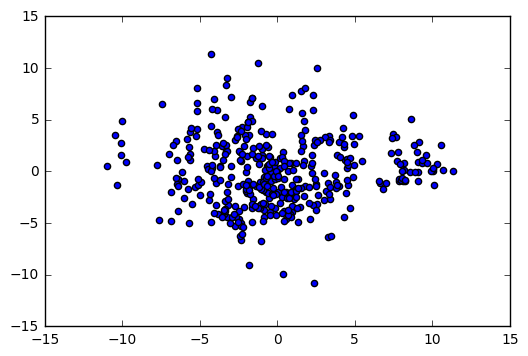

In [51]:
plt.scatter(t[:, 0], t[:, 1])

Cluster organization is not very coherent.
Clusters corresponding to invididual atypical faces (n = 10 images for a face) are evident:

In [60]:
np.where(t[:, 0] < -8) # successive indices corresponding to individual face

(array([53, 54, 55, 56, 57, 58, 59]),)

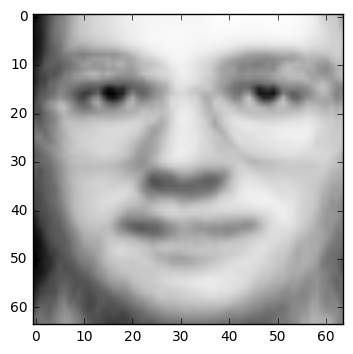

In [64]:
plt.imshow(invt[54].reshape(64, 64), cmap=plt.cm.Greys_r) # atypical face

In [66]:
km = KMeans(n_clusters = 4)

In [70]:
cluster_nums = km.fit_predict(t)

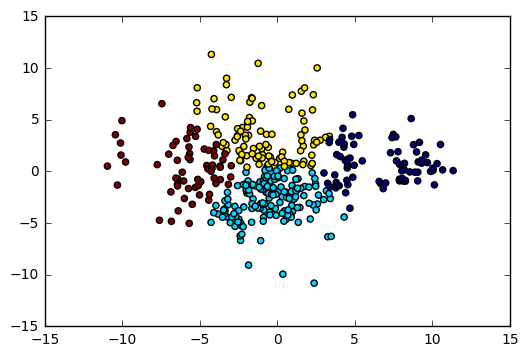

In [72]:
plt.scatter(t[:, 0], t[:, 1], c = cluster_nums)
# KMeans just separates four quadrants which is not a highly-organized cluster structure

In [80]:
# faces = X

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [145]:
def learn(X, dim, epochs = 15):
    net = nn.Sequential(nn.Linear(4096, 200), nn.Sigmoid(), nn.Linear(200, dim), nn.Sigmoid(), nn.Linear(dim, 200),
             nn.Sigmoid(), nn.Linear(200, 4096), nn.Sigmoid())
    lossf = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    batchsize = 64
    iters = int(np.ceil(float(X.shape[0]) / batchsize))
    losses = np.zeros((epochs * iters))
    invar = Variable(torch.Tensor())
    for ep in tqdm(xrange(epochs)):
        p = np.random.permutation(X.shape[0])
        X = X[p, :]
        for i in xrange(iters):
            batch = X[i * batchsize:(i + 1) * batchsize]
            ten = torch.from_numpy(batch).float()
            invar.data = ten
            y = net.forward(invar)
            loss = lossf(y, invar)
            losses[ep * iters + i] = loss.data.numpy()[0] #[0]?
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return net, losses

In [137]:
net, losses = learn(X, 10)

100%|██████████| 15/15 [00:06<00:00,  2.54it/s]


<i> 2.2 Какое качество восстановления удалось получить?</i>

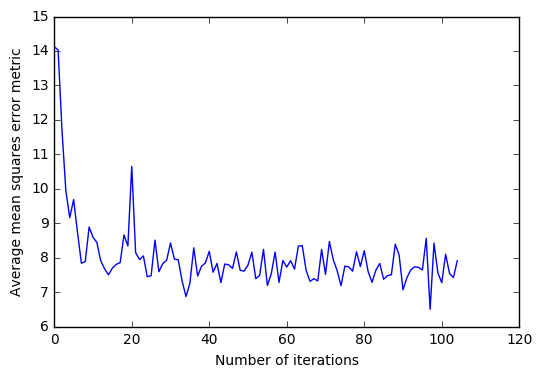

In [138]:
plt.plot(losses * X.shape[0])
plt.xlabel('Number of iterations')
plt.ylabel('Average mean squares error metric')

Quality is on par with 80 component PCA

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

In [139]:
dims = [5, 10, 25, 45]
losses = []
for dim in dims:
    net, dim_losses = learn(X, dim)
    losses.append(dim_losses)

100%|██████████| 15/15 [00:06<00:00,  2.63it/s]


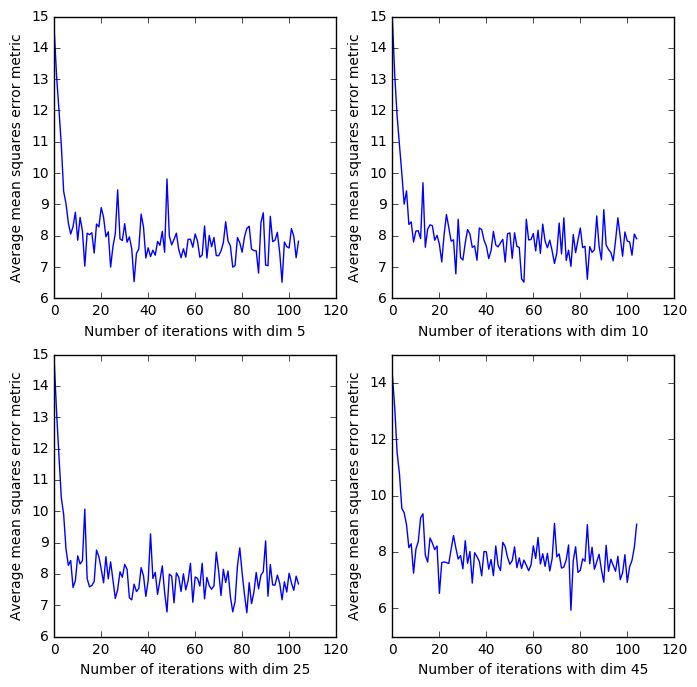

In [144]:
plt.figure(figsize=(8, 8))
nrows = 2
for i in xrange(len(losses)):
    plt.subplot(nrows, nrows, i+1)
    plt.plot(losses[i] * X.shape[0])
    plt.xlabel('Number of iterations with dim ' + str(dims[i]))
    plt.ylabel('Average mean squares error metric')
plt.show()

In [ ]:
# Results appear to be roughly equal

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [219]:
net, losses = learn(X, 2, epochs = 30)

100%|██████████| 30/30 [00:12<00:00,  2.60it/s]


In [220]:
rep = None
def hook(module, inp, outp):
    global rep
    rep = outp

In [221]:
list(net.modules())[4].register_forward_hook(hook) # hook sigmoid output to save it

In [222]:
outp = net.forward(Variable(torch.from_numpy(X).float()))

In [223]:
repnums = rep.data.numpy()

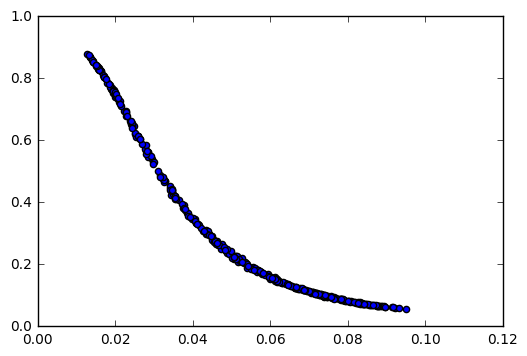

In [224]:
plt.scatter(repnums[:, 0], repnums[:, 1])

In [ ]:
# looks like a curve with equally distributed mass and without any cluster structure

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: